In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from sklearn.model_selection import train_test_split

### Perform triangulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


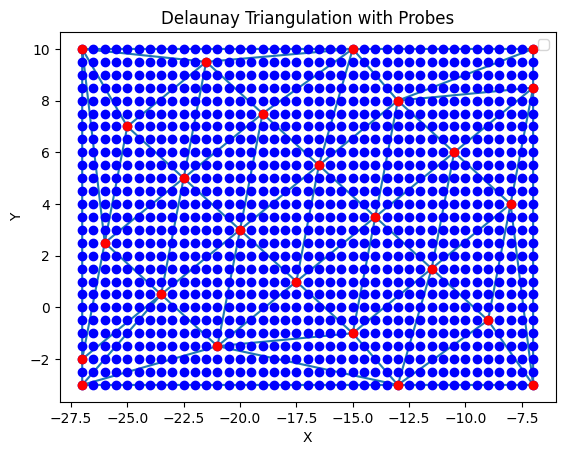

In [9]:
# Define scene area
x_min, x_max = -27, -7
y_min, y_max = -3, 10

# Desired number of probes (approximately 20)
num_probes = 24 # Adjust as needed (excluding corner probes)

# Generate valid grid points within the scene area
# x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
# valid_points = np.vstack((x_grid.flatten(), y_grid.flatten())).T

# Generate valid grid point within the scene area with step size 0.5
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max + 0.5, 0.5), np.arange(y_min, y_max + 0.5, 0.5))
valid_points = np.vstack((x_grid.flatten(), y_grid.flatten())).T

# Select corner probes explicitly
corner_probes = np.array([
    [x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max]
])

# Select remaining probes (excluding corner probes) using slicing
remaining_points = valid_points[~np.isin(valid_points, corner_probes).all(axis=1)]
# exclude len(remaining_points) // (num_probes - 4) points from the start point
exc = int((len(remaining_points) // (num_probes - 4)) / 2)
remaining_points = remaining_points[exc:]

remaining_probes = remaining_points[::len(remaining_points) // (num_probes - 4)]

# Combine corner and remaining probes
probes = np.concatenate((corner_probes, remaining_probes))

# # Print probe locations
# print("Probe locations:")
# for probe in probes:
#     print(f"  x: {probe[0]}, y: {probe[1]}")

# Perform Delaunay triangulation
tri = Delaunay(probes)

# Plot the triangulation with probes and valid points
plt.triplot(probes[:, 0], probes[:, 1], tri.simplices)
plt.plot(valid_points[:, 0], valid_points[:, 1], 'bo')
plt.plot(probes[:, 0], probes[:, 1], 'ro')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation with Probes')
plt.legend()
plt.show()

In [10]:
def get_containing_triangle(point, probes, tri):
  """
  This function finds the triangle containing a given point using the Delaunay triangulation.

  Args:
      point: A numpy array representing the point (x, y) coordinates.
      probes: A numpy array containing the probe locations.
      tri: A Delaunay triangulation object from scipy.spatial.Delaunay.

  Returns:
      A numpy array containing the vertices of the triangle that contains the point, 
      or None if the point is outside the convex hull of the probes.
  """
  # Use the `find_simplex` method of the Delaunay triangulation
  simplex_index = tri.find_simplex(point)

  # Check if the point is outside the convex hull
  if simplex_index == -1:
    return None

  # Get the vertices of the containing triangle
  return probes[tri.simplices[simplex_index]]

# Example usage:
# Select a valid point (modify this to your desired point)
valid_point = valid_points[10]  # Replace with your specific valid point coordinates

# Find the containing triangle
containing_triangle = get_containing_triangle(valid_point, probes, tri)

if containing_triangle is None:
  print("Point is outside the convex hull of the probes.")
else:
  print("Point", valid_point, "is located in triangle:")
  print(containing_triangle)


Point [-22.  -3.] is located in triangle:
[[-13.   -3. ]
 [-21.   -1.5]
 [-27.   -3. ]]


In [13]:
# def get_barycentric_weights(point, triangle):
#   """
#   This function calculates the barycentric weights of a point within a triangle.

#   Args:
#       point: A numpy array representing the point (x, y) coordinates.
#       triangle: A numpy array containing the vertices of the triangle (3x2 shape).

#   Returns:
#       A numpy array containing the barycentric weights (u, v, w) of the point 
#       relative to the triangle vertices, or None if the point is not within the triangle.
#   """

#   # Calculate edge vectors of the triangle
#   v1 = triangle[1] - triangle[0]  # vector from vertex 0 to vertex 1
#   v2 = triangle[2] - triangle[0]  # vector from vertex 0 to vertex 2

#   # Calculate the vector from the triangle origin (vertex 0) to the point
#   v3 = point - triangle[0]

#   # Compute the determinant of the matrix formed by the edge vectors
#   det = np.linalg.det(np.vstack([v1, v2]))

#   # Check if the point is within the triangle (positive determinant)
#   if det <= 0:
#     return None

#   # Calculate barycentric coordinates using Cramer's rule
#   u = np.linalg.det(np.vstack([v3, v2])) / det
#   v = np.linalg.det(np.vstack([v1, v3])) / det
#   w = 1 - u - v

#   return np.array([u, v, w])

def get_barycentric_weights(point, triangle):
    # Extract triangle vertices
    x1, y1 = triangle[0]
    x2, y2 = triangle[1]
    x3, y3 = triangle[2]
    
    # Calculate vectors
    v0 = np.array([x3 - x1, y3 - y1])
    v1 = np.array([x2 - x1, y2 - y1])
    v2 = np.array([point[0] - x1, point[1] - y1])
    
    # Calculate dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)
    
    # Calculate barycentric weights
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom
    w = 1 - u - v
    
    return np.array([w, v, u])


valid_point = valid_points[9]  # Replace with your specific valid point coordinates
# valid_point = np.array([-18, 9])
containing_triangle = get_containing_triangle(valid_point, probes, tri)

# Example usage (assuming you have a containing triangle from previous step)
if containing_triangle is not None:
  barycentric_weights = get_barycentric_weights(valid_point, containing_triangle)
  print("Barycentric weights of", valid_point, "in the triangle:")
  print(barycentric_weights)
  print("triangle: ", containing_triangle)

Barycentric weights of [-22.5  -3. ] in the triangle:
[0.32142857 0.         0.67857143]
triangle:  [[-13.   -3. ]
 [-21.   -1.5]
 [-27.   -3. ]]


### Neural network

In [18]:
# Preprocess the data
barycentric_coords = []
images = []
depth_images = []
z = 1.7
for point in valid_points:
    containing_triangle = get_containing_triangle(point, probes, tri)
    if containing_triangle is not None:
        barycentric_weights = get_barycentric_weights(point, containing_triangle)
        barycentric_coords.append(barycentric_weights)

        # coresponding images are located in triangle's vertices
        image1_name = f"camera_{containing_triangle[0][0]}_{containing_triangle[0][1]}_{z} image0001.png"
        image2_name = f"camera_{containing_triangle[1][0]}_{containing_triangle[1][1]}_{z} image0001.png"
        image3_name = f"camera_{containing_triangle[2][0]}_{containing_triangle[2][1]}_{z} image0001.png"
        
        depth1_name = f"camera_{containing_triangle[0][0]}_{containing_triangle[0][1]}_{z} depth0001.png"
        depth2_name = f"camera_{containing_triangle[1][0]}_{containing_triangle[1][1]}_{z} depth0001.png"
        depth3_name = f"camera_{containing_triangle[2][0]}_{containing_triangle[2][1]}_{z} depth0001.png"

        # open images and get the pixel values
        dir = "./DepthImages_new/"
        image1 = plt.imread(dir + image1_name)
        image2 = plt.imread(dir + image2_name)
        image3 = plt.imread(dir + image3_name)

        depth1 = plt.imread(dir + depth1_name)
        depth2 = plt.imread(dir + depth2_name)
        depth3 = plt.imread(dir + depth3_name)

        # delete alpha channel
        image1 = image1[:, :, :3]
        image2 = image2[:, :, :3]
        image3 = image3[:, :, :3]

        depth1 = depth1[:, :, :3]
        depth2 = depth2[:, :, :3]
        depth3 = depth3[:, :, :3]

        images.append([image1, image2, image3])
        depth_images.append([depth1, depth2, depth3])



# ground truth images
images_interpolated= []
for point in valid_points:
    image_name = f"camera_{point[0]}_{point[1]}_{z} image0001.png"
    image = plt.imread(dir + image_name)
    image = image[:, :, :3]
    images_interpolated.append(image)

images_interpolated = np.array(images_interpolated)
print(images_interpolated.shape)

# Convert lists to numpy arrays	
barycentric_coords = np.array(barycentric_coords)
print(barycentric_coords.shape)

images_train = np.array(images)
print(images_train.shape)

(1107, 256, 256, 3)
(1107, 3)
(1107, 3, 256, 256, 3)


In [19]:
# Train test split

# Split the data into train and temp sets
# barycentric_train_temp, barycentric_test, images_train_temp, images_test, images_interpolated_train_temp, images_interpolated_test = train_test_split(barycentric_coords, images, images_interpolated, test_size=0.2, random_state=42)
# include also depth images in the split
barycentric_train_temp, barycentric_test, images_train_temp, images_test, images_interpolated_train_temp, images_interpolated_test, depth_images_train_temp, depth_images_test = train_test_split(barycentric_coords, images, images_interpolated, depth_images, test_size=0.2, random_state=42)

# Split the temp set into train and validation sets
#barycentric_train, barycentric_val, images_train, images_val, images_interpolated_train, images_interpolated_val = train_test_split(barycentric_train_temp, images_train_temp, images_interpolated_train_temp, test_size=0.25, random_state=42)
barycentric_train, barycentric_val, images_train, images_val, images_interpolated_train, images_interpolated_val, depth_images_train, depth_images_val = train_test_split(barycentric_train_temp, images_train_temp, images_interpolated_train_temp, depth_images_train_temp, test_size=0.25, random_state=42)

# convert all to numpy arrays
barycentric_train = np.array(barycentric_train)
barycentric_val = np.array(barycentric_val)
barycentric_test = np.array(barycentric_test)

images_train = np.array(images_train)
images_val = np.array(images_val)
images_test = np.array(images_test)

images_interpolated_train = np.array(images_interpolated_train)
images_interpolated_val = np.array(images_interpolated_val)
images_interpolated_test = np.array(images_interpolated_test)

depth_images_train = np.array(depth_images_train)
depth_images_val = np.array(depth_images_val)
depth_images_test = np.array(depth_images_test)


print(depth_images_train.shape)
print(depth_images_val.shape)
print(depth_images_test.shape)
# barycentric_train, barycentric_val, barycentric_test now contain the barycentric coordinates for training, validation, and testing respectively
# images_train, images_val, images_test now contain the corresponding images
# images_interpolated_train, images_interpolated_val, images_interpolated_test now contain the corresponding ground truth interpolated images

(663, 3, 256, 256, 3)
(222, 3, 256, 256, 3)
(222, 3, 256, 256, 3)


In [9]:
import tensorflow as tf
from keras import layers, models

# Define loss function
def custom_loss(y_true, y_pred):
    return tf.keras.losses.MSE(y_true, y_pred)

# print shapes
# print(barycentric_train.shape)
# print(images_train.shape)
# print(images_interpolated_train.shape)
# print(barycentric_val.shape)
# print(images_val.shape)
# print(images_interpolated_val.shape)

In [10]:
def create_model(input_shape):
    input_coords = layers.Input(shape=(3,))
    input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Separate convolutional layers for processing each image
    conv_outputs = []
    for i in range(3):
        conv_output = layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding="valid")(input_images[:, i, :, :, :])
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Flatten()(conv_output)
        conv_outputs.append(conv_output)
    
    # Concatenate barycentric coordinates with CNN outputs
    cnn_output = layers.Concatenate()(conv_outputs)
    merged_output = layers.Concatenate()([input_coords, cnn_output])
    
    # Fully connected layers for regression
    x = layers.Dense(128, activation='relu')(merged_output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(256 * 256 * 3, activation='relu')(x)  # Adjust the size to match the desired output shape
    x = layers.Reshape((256, 256, 3))(x)  # Reshape to the desired output shape
    output = layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), activation='linear', padding='same')(x)
    
    # print output shape
    print(output.shape)

    model = models.Model(inputs=[input_coords, input_images], outputs=output)
    return model

input_shape = (3, 256, 256, 3)

model = create_model(input_shape)
model.summary()
model.compile(optimizer='adam', loss=custom_loss)


(None, 256, 256, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 252, 252,  │      4,864 │ get_item[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 252, 252,  │      4,864 │ get_item_1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 252, 252,  │      4,864 │ get_item_2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 126, 126,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 126, 126,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 126, 126,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1016064)   │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1016064)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1016064)   │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3048192)   │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3048195)   │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 390,169,0… │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]     

 Total params: 402,971,684 (1.50 GB)

 Trainable params: 402,971,684 (1.50 GB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# def build_interpolation_model(input_shape):
#     # Input layers
#     input_coords = layers.Input(shape=(3,))
#     input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    
#     # Image Processing Branch
#     conv_outputs = []
#     for i in range(3):
#         conv_output = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu')(input_images[:, i, :, :, :])
#         conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
#         conv_output = layers.Flatten()(conv_output)
#         conv_outputs.append(conv_output)
#     cnn_output = layers.Concatenate()(conv_outputs)
    
#     # Barycentric Coordinates Processing Branch
#     x = layers.Dense(128, activation='relu')(input_coords)
#     x = layers.Dense(64, activation='relu')(x)
    
#     # Combining both branches
#     merged_output = layers.Concatenate()([cnn_output, x])
    
#     # Interpolation
#     x = layers.Dense(256, activation='relu')(merged_output)
#     x = layers.Reshape((16, 16, 1))(x)
#     x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
#     x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
#     x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
#     x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(2, 2), padding='same')(x)
    
#     # Output
#     output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
#     # Creating model
#     model = models.Model(inputs=[input_coords, input_images], outputs=output)
#     return model



# def build_interpolation_model(input_shape):
#     # Input layers
#     input_coords = layers.Input(shape=(3,))
#     input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
#     # Image Processing Branch
#     conv_outputs = []
#     for i in range(3):
#         conv_output = input_images[:, i, :, :, :]
#         conv_output = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
#         conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
#         conv_output = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
#         conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
#         conv_output = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
#         conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
#         conv_output = layers.Flatten()(conv_output)
#         conv_outputs.append(conv_output)
#     cnn_output = layers.Concatenate()(conv_outputs)
    
#     # Barycentric Coordinates Processing Branch
#     x = layers.Dense(128, activation='relu')(input_coords)
#     x = layers.Dense(64, activation='relu')(x)
    
#     # Combining both branches
#     merged_output = layers.Concatenate()([cnn_output, x])
    
#     # Interpolation
#     x = layers.Dense(256, activation='relu')(merged_output)
#     x = layers.Reshape((16, 16, 1))(x)
#     x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
#     x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
#     x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
#     x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(2, 2), padding='same')(x)
    
#     # Output
#     output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
#     # Creating model
#     model = models.Model(inputs=[input_coords, input_images], outputs=output)
#     return model


def build_interpolation_model(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Image Processing Branch
    conv_outputs = []
    for i in range(3):
        conv_output = input_images[:, i, :, :, :]
        conv_output = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Conv2D(filters=512, kernel_size=(4, 4), activation='relu', padding='same')(conv_output)
        conv_output = layers.MaxPooling2D(pool_size=(2, 2))(conv_output)
        conv_output = layers.Flatten()(conv_output)
        conv_outputs.append(conv_output)
    cnn_output = layers.Concatenate()(conv_outputs)
    
    # Barycentric Coordinates Processing Branch
    x = layers.Dense(256, activation='relu')(input_coords)
    x = layers.Dense(128, activation='relu')(x)
    
    # Combining both branches
    merged_output = layers.Concatenate()([cnn_output, x])
    
    # Interpolation
    x = layers.Dense(512, activation='relu')(merged_output)
    x = layers.Reshape((16, 16, 2))(x)
    x = layers.Conv2DTranspose(filters=512, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(2, 2), padding='same')(x)
    
    # Output
    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_images], outputs=output)
    return model


# Define image dimensions
image_height, image_width, num_channels = 256, 256, 3

# Define number of epochs and batch size
num_epochs = 10
batch_size = 32

# Create the model
input_shape = (3, image_height, image_width, num_channels)

# Build the model
interpolation_model = build_interpolation_model(input_shape)
interpolation_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      6,272 │ get_item_3[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │      6,272 │ get_item_4[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      6,272 │ get_item_5[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    524,544 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    524,544 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │    524,544 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │  2,097,664 │ max_pooling2d_4[

 Total params: 815,936,790 (3.04 GB)

 Trainable params: 815,936,790 (3.04 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras import config, callbacks


callback = callbacks.EarlyStopping(monitor='loss', patience=3)

# interpolation_model.compile(optimizer='adam', loss=custom_loss)
# use adamW optimizer
interpolation_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)

batch_size = 32
num_epochs = 100


# model.compile(optimizer='adam', loss=custom_loss)
config.disable_traceback_filtering()
# Train the model
interpolation_model.fit([barycentric_train, images_train], images_interpolated_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val], images_interpolated_val), callbacks=[callback])


# Evaluate the model
loss = interpolation_model.evaluate([barycentric_test, images_test], images_interpolated_test)
print("Test Loss:", loss)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 211s 34s/step - MeanSquaredError: 0.1055 - loss: 0.1055 - val_MeanSquaredError: 0.1056 - val_loss: 0.1056
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 206s 34s/step - MeanSquaredError: 0.1053 - loss: 0.1053 - val_MeanSquaredError: 0.1052 - val_loss: 0.1052
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 205s 34s/step - MeanSquaredError: 0.1047 - loss: 0.1047 - val_MeanSquaredError: 0.1048 - val_loss: 0.1048
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 204s 34s/step - MeanSquaredError: 0.1049 - loss: 0.1049 - val_MeanSquaredError: 0.1040 - val_loss: 0.1040
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 206s 34s/step - MeanSquaredError: 0.1030 - loss: 0.1030 - val_MeanSquaredError: 0.0915 - val_loss: 0.0915
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 205s 34s/step - MeanSquaredError: 0.0815 - loss: 0.0815 - val_MeanSquaredError: 0.0672 - val_loss: 0.0672
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 217s 36s/step - MeanSquaredError: 0.0604 - loss: 0.0604 - val_MeanSquaredError: 0.0383 - val_loss: 0.0383

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


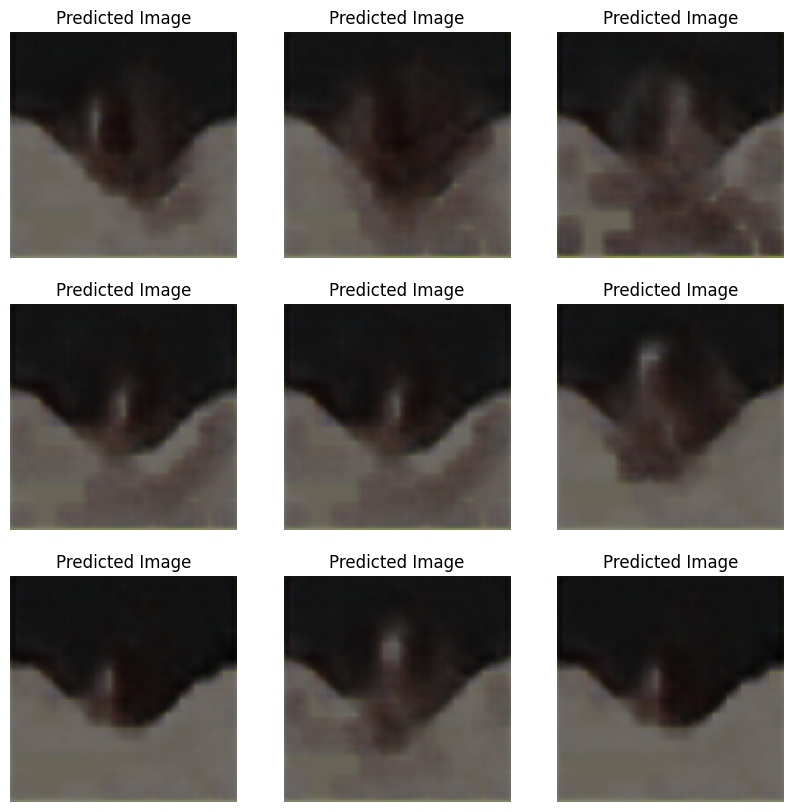

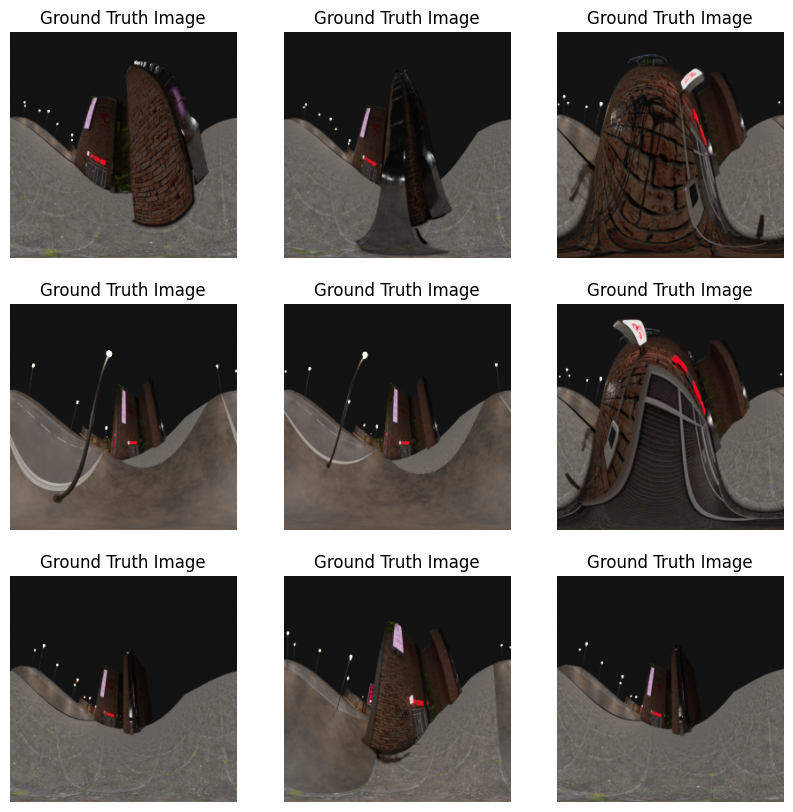

In [11]:


# Predict the interpolated images
predicted_images = interpolation_model.predict([barycentric_test, images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_interpolated_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()


In [12]:
# save the model
model_file_path = 'interpolation_model.h5'

# Save the model
interpolation_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)


Model saved successfully at: interpolation_model.h5


### Add depth images to the neural network

In [13]:
from keras import layers, models

def build_model(input_shape):
    # Input layers
    input_coords = layers.Input(shape=(3,))
    input_rgb_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    input_depth_images = layers.Input(shape=input_shape)  # Shape (None, 3, image_height, image_width, num_channels)
    
    # Image Processing Branch
    conv_outputs_rgb = []
    conv_outputs_depth = []
    for i in range(3):
        # RGB image processing
        conv_output_rgb = input_rgb_images[:, i, :, :, :]
        conv_output_rgb = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_rgb)
        conv_output_rgb = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_rgb)
        conv_output_rgb = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_rgb)
        conv_output_rgb = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_rgb)
        conv_output_rgb = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_rgb)
        conv_output_rgb = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_rgb)
        conv_output_rgb = layers.Flatten()(conv_output_rgb)
        conv_outputs_rgb.append(conv_output_rgb)
        
        # Depth image processing
        conv_output_depth = input_depth_images[:, i, :, :, :]
        conv_output_depth = layers.Conv2D(filters=64, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Conv2D(filters=256, kernel_size=(4, 4), activation='relu', padding='same')(conv_output_depth)
        conv_output_depth = layers.MaxPooling2D(pool_size=(2, 2))(conv_output_depth)
        conv_output_depth = layers.Flatten()(conv_output_depth)
        conv_outputs_depth.append(conv_output_depth)
    
    cnn_output_rgb = layers.Concatenate()(conv_outputs_rgb)
    cnn_output_depth = layers.Concatenate()(conv_outputs_depth)
    
    # Barycentric Coordinates Processing Branch
    x = layers.Dense(128, activation='relu')(input_coords)
    x = layers.Dense(64, activation='relu')(x)
    
    # Combining both branches
    merged_output = layers.Concatenate()([cnn_output_rgb, cnn_output_depth, x])
    
    # Interpolation
    x = layers.Dense(256, activation='relu')(merged_output)
    x = layers.Reshape((16, 16, 1))(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), activation='relu', strides=(2, 2), padding='same')(x)
    x = layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), activation='linear', strides=(2, 2), padding='same')(x)
    
    # Output
    output = layers.Conv2D(filters=3, kernel_size=(4, 4), activation='sigmoid', padding='same')(x)
    
    # Creating model
    model = models.Model(inputs=[input_coords, input_rgb_images, input_depth_images], outputs=output)
    return model


input_shape = (3, image_height, image_width, num_channels)
model_depth = build_model(input_shape)


model_depth.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 256, 256,  │          0 │ input_layer_8[0]… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_9[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_11[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_13[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_10[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_12[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      3,136 │ get_item_14[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 128, 128,  │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 128, 128,  │          0 │ conv2d_35[0][0] 

 Total params: 407,294,998 (1.52 GB)

 Trainable params: 407,294,998 (1.52 GB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
num_epochs = 20
batch_size = 32


model_depth.compile(
    optimizer= 'adam',
    loss='mse',
    metrics=[
        'MeanSquaredError',
    ]
)
model_depth.fit([barycentric_train, images_train, depth_images_train], images_interpolated_train, epochs=num_epochs, batch_size=batch_size, validation_data=([barycentric_val, images_val, depth_images_val], images_interpolated_val))

# evaluate the model
loss = model_depth.evaluate([barycentric_test, images_test, depth_images_test], images_interpolated_test)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 117s 18s/step - MeanSquaredError: 0.1048 - loss: 0.1048 - val_MeanSquaredError: 0.0989 - val_loss: 0.0989
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 17s/step - MeanSquaredError: 0.0946 - loss: 0.0946 - val_MeanSquaredError: 0.0577 - val_loss: 0.0577
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 122s 21s/step - MeanSquaredError: 0.0394 - loss: 0.0394 - val_MeanSquaredError: 0.0238 - val_loss: 0.0238
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 147s 25s/step - MeanSquaredError: 0.0227 - loss: 0.0227 - val_MeanSquaredError: 0.0181 - val_loss: 0.0181
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 122s 19s/step - MeanSquaredError: 0.0187 - loss: 0.0187 - val_MeanSquaredError: 0.0153 - val_loss: 0.0153
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 17s/step - MeanSquaredError: 0.0150 - loss: 0.0150 - val_MeanSquaredError: 0.0109 - val_loss: 0.0109
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 112s 19s/step - MeanSquaredError: 0.0102 - loss: 0.0102 - val_MeanSquaredError: 0.0091 - val_loss: 0.0091
Epoch 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


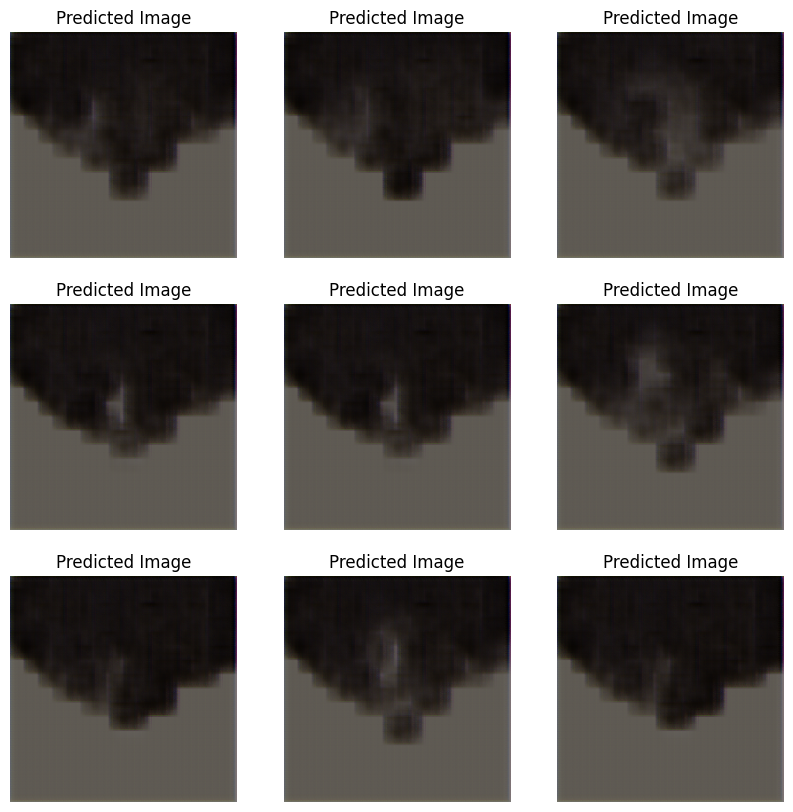

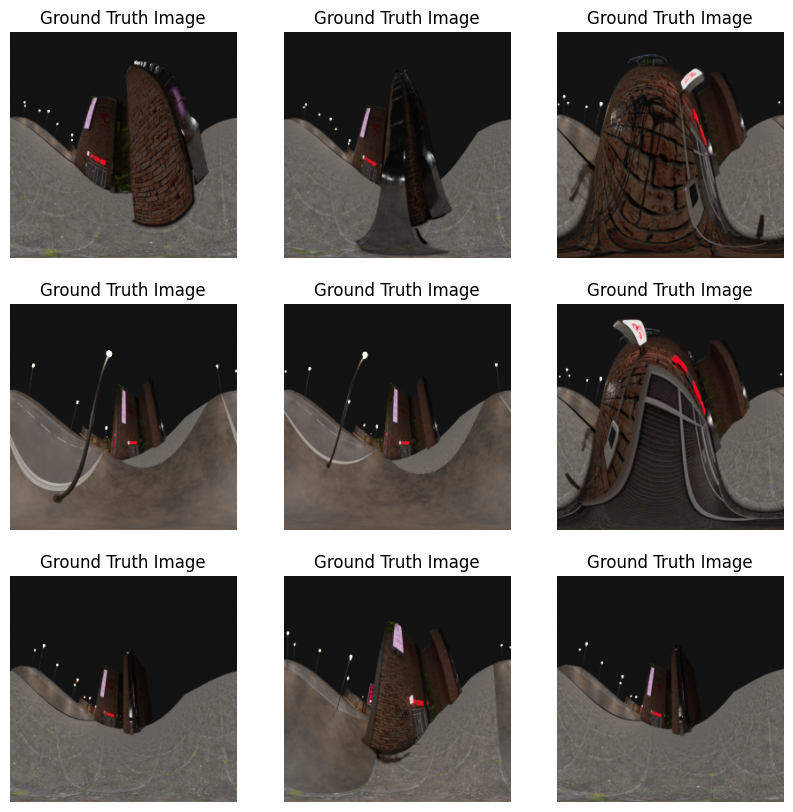

In [23]:

# Predict the interpolated images
predicted_images = model_depth.predict([barycentric_test, images_test, depth_images_test])

# Plot the predicted and ground truth images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(predicted_images[i])
    plt.axis('off')
    plt.title('Predicted Image')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_interpolated_test[i])
    plt.axis('off')
    plt.title('Ground Truth Image')
plt.show()


In [24]:
# save the model 
model_file_path = 'depth_model.h5'

# Save the model
model_depth.save(model_file_path)

print("Model saved successfully at:", model_file_path)

Model saved successfully at: depth_model.h5


TODO: združi use 3 rgba slike, depth slike iz kornerjeu trikotnika in baricentrične koordinate
in nato to uporabi za input v nevronsko mrežo